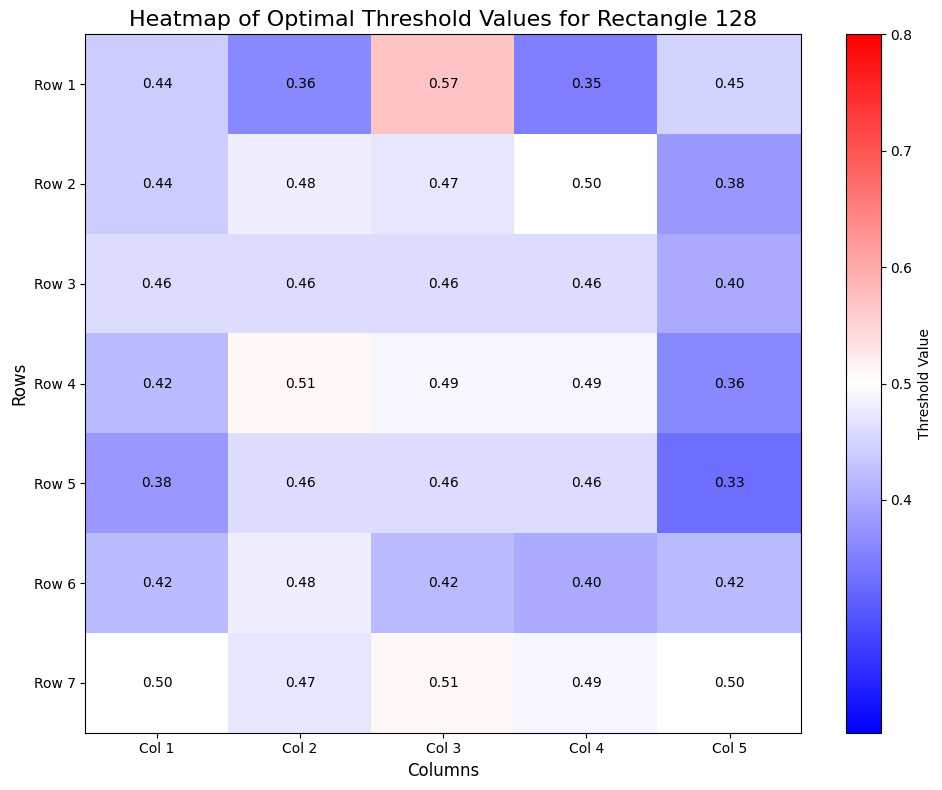

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Cross 16
threshold_values = np.array([
    [0.56, 0.8, 0.76, 0.8, 0.65],
    [0.47, 0.67, 0.5, 0.53, 0.64],
    [0.7, 0.57, 0.66, 0.64, 0.53],
    [0.65, 0.68, 0.7, 0.67, 0.65],
    [0.55, 0.75, 0.72, 0.69, 0.66],
    [0.55, 0.65, 0.66, 0.6, 0.57],
    [0.47, 0.67, 0.65, 0.65, 0.67]
])

# Cross 32
threshold_values = np.array([
    [0.44, 0.51, 0.44, 0.42, 0.43],
    [0.49, 0.49, 0.48, 0.52, 0.44],
    [0.57, 0.54, 0.58, 0.54, 0.48],
    [0.54, 0.53, 0.54, 0.54, 0.54],
    [0.49, 0.49, 0.54, 0.50, 0.54],
    [0.56, 0.52, 0.51, 0.55, 0.51],
    [0.48, 0.54, 0.50, 0.47, 0.50]
])

# Cross 64
threshold_values = np.array([
    [0.44, 0.46, 0.56, 0.50, 0.50],
    [0.43, 0.40, 0.46, 0.45, 0.46],
    [0.43, 0.44, 0.45, 0.45, 0.45],
    [0.48, 0.48, 0.49, 0.50, 0.47],
    [0.46, 0.46, 0.54, 0.49, 0.48],
    [0.46, 0.47, 0.50, 0.46, 0.50],
    [0.46, 0.48, 0.49, 0.53, 0.68]
])

# Rectangle 128
threshold_values = np.array([
    [0.44, 0.36, 0.57, 0.35, 0.45],
    [0.44, 0.48, 0.47, 0.50, 0.38],
    [0.46, 0.46, 0.46, 0.46, 0.40],
    [0.42, 0.51, 0.49, 0.49, 0.36],
    [0.38, 0.46, 0.46, 0.46, 0.33],
    [0.42, 0.48, 0.42, 0.40, 0.42],
    [0.50, 0.47, 0.51, 0.49, 0.50]
])

# Define a custom colormap: blue for low, white for middle, red for high
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    ['blue', 'white', 'red']
)

# Set normalization from 0.2 (low) to 0.8 (high)
norm = mcolors.Normalize(vmin=0.2, vmax=0.8)

# Generate the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(threshold_values, cmap=custom_cmap, norm=norm, aspect='auto', origin='upper')

# Add annotations for each cell
for i in range(threshold_values.shape[0]):
    for j in range(threshold_values.shape[1]):
        plt.text(j, i, f"{threshold_values[i, j]:.2f}", ha='center', va='center', color='black')

# Customizing the plot
cbar = plt.colorbar(label='Threshold Value')
cbar.set_ticks([0.4, 0.5, 0.6, 0.7, 0.8])
cbar.set_ticklabels(['0.4', '0.5', '0.6', '0.7', '0.8'])

plt.title('Heatmap of Optimal Threshold Values for Rectangle 128', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)
plt.xticks(range(threshold_values.shape[1]), [f'Col {i+1}' for i in range(threshold_values.shape[1])])
plt.yticks(range(threshold_values.shape[0]), [f'Row {i+1}' for i in range(threshold_values.shape[0])])
plt.tight_layout()

plt.savefig('rectangle 128.png')
plt.show()
